In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-mnist/fashion_mnist1.csv


In [123]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os


In [3]:
# Reading the fashion_mnist1 data
file_path = '/kaggle/input/fashion-mnist/fashion_mnist1.csv'
df = pd.read_csv(file_path)

print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

df.head()
X=df.drop('label',axis=1).values #pixel feature
labels= df['label'].values #label classes

Number of rows: 10000
Number of columns: 785


#### 1. Dimension reduction using principal component analysis (PCA)

In [4]:
X=df.drop('label',axis=1).values #pixel feature
labels= df['label'].values #label classes

1.1 Using Singular-Value Decomposition (SVD) method, please decompose 1st and 2nd principal
components and project them to the data.
Please draw 2D plot using the 1st and 2nd principal components.
Please legend different colors for the 10 labels in the graph

In [5]:
X_centered= X-X.mean(axis=0)

In [6]:
U, S, V = np.linalg.svd(X_centered)

In [7]:
# component 1
C1=V.T[:,0]

In [8]:
#component 2
C2=V.T[:,1]

In [9]:
X_pca = X_centered @ V.T[:, :2]

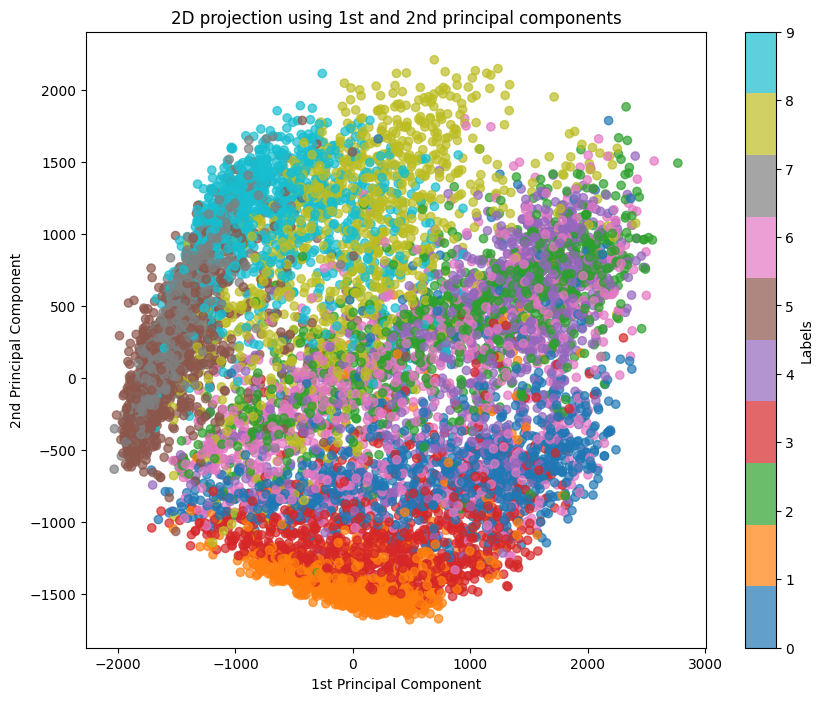

In [10]:
# Plot the 2D scatter plot using the 1st and 2nd principal components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title("2D projection using 1st and 2nd principal components")
plt.colorbar(scatter, label='Labels')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()


1.2 As we discussed during the class, we can compress images using PCA.
𝐴 ≈ 𝑈𝑘∑𝑘𝑉𝑘
𝑇
Please select 10 images. The selected images should have different labels. Please compress the images
using k=2, 5, 10. Then, visualize the original images and the compressed images with different k

In [11]:
selected_images_df= df.groupby('label').head(1)
selected_images = selected_images_df.drop(columns=['label']).values.reshape(-1, 28, 28)
selected_labels = selected_images_df['label'].values

In [12]:
selected_labels

array([5, 7, 6, 9, 4, 8, 1, 3, 0, 2])

In [13]:
def compress_image(image, k):
    Ui, Si, Vi = np.linalg.svd(image, full_matrices=False)
    compressed_image = np.dot(Ui[:, :k], np.dot(np.diag(Si[:k]), Vi[:k, :]))
    return compressed_image

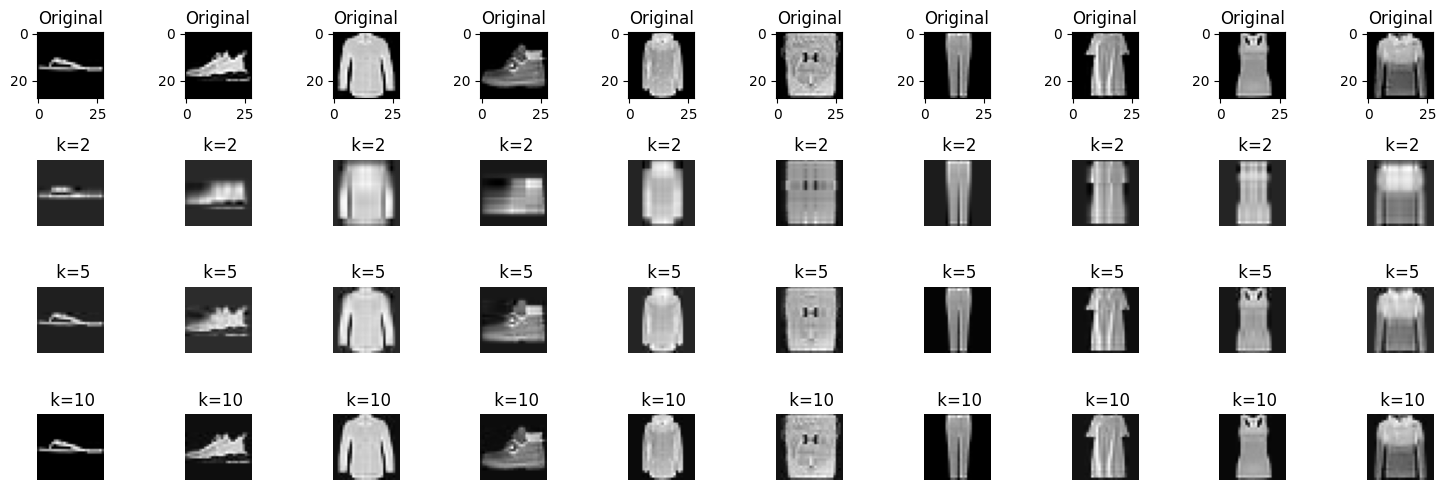

In [14]:
k_values = [2, 5, 10] 
fig, axes = plt.subplots(4, 10, figsize=(15, 5))


for i, img in enumerate(selected_images):
    # Original images in row 1
    ax_original = axes[0, i]
    ax_original.imshow(img, cmap='gray')
    ax_original.set_title("Original")

    # Compressed images
    for j, k in enumerate(k_values):
        compressed_img = compress_image(img, k)
        ax_compressed = axes[j + 1, i]
        ax_compressed.imshow(compressed_img, cmap='gray') 
        ax_compressed.set_title(f" k={k}")
        ax_compressed.axis('off')

plt.tight_layout()
plt.show()


From the 2D PCA plot of the Fashion MNIST, some degree of clustering of data points by the class labels can be observed, and although there is class overlap, it is most likely that while valuable, PCA alone is not enough to segregate the fashion items based off only two components. This implies that more components or intricate techniques would be needed for more clear discrimination in class. On the other hand, the image compression through SVD has shown that optimal detail of images is achieved as the number of singular values (k) is increased. At k = 2 where k is the number of singular values used in the reconstructions, the images are so distorted such that only the faint outlines of objects are seen, k = 10 ensures most key features and details are easy to see thus making the objects recognizable with ease. These facts therefore provide evidence that SVD can be a viable way to compress images whilst still retaining important visual information and when a reasonable compression and quality trade off is sought. Both methods reinforce the concept of the trade off between dimensionality reduction and using enough data for the tasks of classification and recognition.

#### 2. Dimension reduction using t-SNE

2.1 Please build t-SNE algorithm from scratch

References:

van der Maaten, L., & Hinton, G. (2008). Visualizing Data using t-SNE. Journal of Machine Learning Research, 9(Nov), 2579-2605.

https://towardsdatascience.com/t-sne-from-scratch-ft-numpy-172ee2a61df7

In [139]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
data = pd.read_csv('/kaggle/input/fashion-mnist/fashion_mnist1.csv')

# Extract features and targets
targets = torch.tensor(data['label'].values, dtype=torch.long, device=device)
features = torch.tensor(data.drop(columns=['label']).values, dtype=torch.float32, device=device)

# Normalize features (pixel values between 0 and 1)
features /= 255.0

# t-SNE class
class TSNE:
    def __init__(self, data_points, n_components=2, perplexity=30.0, learning_rate=100, momentum=0.9, n_iter=500):
        self.data_points = data_points
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.n_iter = n_iter
        self.num_samples = data_points.shape[0]
        self.embeddings = torch.randn(self.num_samples, n_components, device=device)
        self.embeddings_previous = torch.zeros_like(self.embeddings, device=device)

    # Compute pairwise affinities P in high-dimensional space
    def high_dimension(self):
        pairwise_distances = torch.cdist(self.data_points, self.data_points, p=2) ** 2  # Shape (n, n)
        # Set diagonal to infinity
        mask = torch.eye(self.num_samples, dtype=torch.bool, device=device)
        pairwise_distances.masked_fill_(mask, float('inf'))
        # Compute P affinities
        P_matrix = torch.exp(-pairwise_distances)
        P_matrix /= torch.sum(P_matrix, dim=1, keepdim=True)
        # Symmetrize P
        P_matrix = (P_matrix + P_matrix.t()) / (2 * self.num_samples)
        self.P_matrix = P_matrix

    # Compute pairwise affinities Q in low-dimensional space
    def low_dimension(self):
        pairwise_distances = torch.cdist(self.embeddings, self.embeddings, p=2) ** 2
        # Set diagonal to zero
        mask = torch.eye(self.num_samples, dtype=torch.bool, device=device)
        pairwise_distances.masked_fill_(mask, 0.0)
        # Compute Q affinities
        Q_matrix = 1 / (1 + pairwise_distances)
        Q_matrix /= torch.sum(Q_matrix, dim=1, keepdim=True)
        self.Q_matrix = Q_matrix

    # Gradient computation for the cost function
    def compute_gradients(self):
        PQ_diff = self.P_matrix - self.Q_matrix  # Shape (n, n)
        # Compute pairwise differences between embeddings
        embeddings_diff = self.embeddings.unsqueeze(1) - self.embeddings.unsqueeze(0)  # Shape (n, n, d)
        # Multiply PQ_diff with embeddings_diff
        gradients = 4 * torch.sum((PQ_diff.unsqueeze(2) * embeddings_diff), dim=1)
        return gradients

    # t-SNE optimization loop
    def run(self):
        self.high_dimension()
        for iteration in range(self.n_iter):
            self.low_dimension()
            gradients = self.compute_gradients()
            
            # Update embeddings with momentum
            embeddings_new = self.embeddings - self.learning_rate * gradients + self.momentum * (self.embeddings - self.embeddings_previous)
            self.embeddings_previous = self.embeddings.clone()
            self.embeddings = embeddings_new.clone()
            
            # Optional: Print progress every 100 iterations
            if (iteration + 1) % 100 == 0 or iteration == 0 or (iteration + 1) == self.n_iter:
                print(f"Iteration {iteration + 1}/{self.n_iter} completed.")

        return self.embeddings


2.2 Using the t-SNE method, please reduce the 784 dimensions to 2 dimensions.
Please try at least 5 different hyperparameters conditions

In [140]:
# Compute the centroids for each class
def compute_centroids(embeddings, targets):
    num_classes = 10  # For Fashion MNIST
    centroids = torch.zeros((num_classes, embeddings.shape[1]), device=device)
    for class_idx in range(num_classes):
        class_embeddings = embeddings[targets == class_idx]
        centroids[class_idx] = torch.mean(class_embeddings, dim=0)
    return centroids

# Compute the sum of squared distances D between centroids
def compute_D(centroids):
    # Compute pairwise distances between centroids
    centroid_distances = torch.pdist(centroids, p=2)
    D = torch.sum(centroid_distances ** 2)
    return D.item()

# Compute the objective function J
def compute_J(embeddings, centroids, targets):
    J = 0.0
    num_classes = 10
    for class_idx in range(num_classes):
        class_data = embeddings[targets == class_idx]
        centroid = centroids[class_idx]
        J += torch.sum((class_data - centroid) ** 2)
    return J.item()


In [141]:
# save embeddings
save_dir = 'embeddings'
os.makedirs(save_dir, exist_ok=True)


In [154]:
embedding_configs = [
    {'learning_rate': 50, 'perplexity': 10, 'n_iter': 10, 'name': 'experiment1'},
    {'learning_rate': 40, 'perplexity': 80.0, 'n_iter': 100, 'name': 'experiment2'},
    {'learning_rate': 500,  'perplexity': 100.0, 'n_iter': 10, 'name': 'experiment3'},
    {'learning_rate': 100, 'perplexity': 50, 'n_iter': 400, 'name': 'experiment4'},
    {'learning_rate': 300,  'perplexity': 40, 'n_iter': 600,  'name': 'experiment5'},
    {'learning_rate': 150,  'perplexity': 40, 'n_iter': 800,  'name': 'experiment6'},
    {'learning_rate': 100,  'perplexity': 40, 'n_iter': 1000,  'name': 'experiment7'},
]


In [155]:
D_values = {}
J_values = {}

for config in embedding_configs:
    print(f"\nRunning t-SNE for {config['name']}...")
    tsne = TSNE(
        data_points=features,
        n_components=2,
        learning_rate=config['learning_rate'],
        momentum=0.9,
        perplexity=config['perplexity'],
        n_iter=config['n_iter']
    )
    embeddings = tsne.run()
    
    # Save embeddings
    embeddings_cpu = embeddings.cpu().detach()
    torch.save(embeddings_cpu, os.path.join(save_dir, f"embeddings_{config['name']}.pt"))
    print(f"Embeddings for {config['name']} saved.")
    
    # Compute centroids, D, and J
    centroids = compute_centroids(embeddings, targets)
    D = compute_D(centroids)
    J = compute_J(embeddings, centroids, targets)
    
    # Save metrics
    with open(os.path.join(save_dir, f"metrics_{config['name']}.txt"), 'w') as f:
        f.write(f"D = {D}\n")
        f.write(f"J = {J}\n")
    
    # Store D and J values
    D_values[config['name']] = D
    J_values[config['name']] = J
    
    print(f"{config['name']}: D = {D}, J = {J}")



Running t-SNE for experiment1...
Iteration 1/10 completed.
Iteration 10/10 completed.
Embeddings for experiment1 saved.
experiment1: D = 44935780.0, J = 3454143823872.0

Running t-SNE for experiment2...
Iteration 1/100 completed.
Iteration 100/100 completed.
Embeddings for experiment2 saved.
experiment2: D = 1628184192.0, J = 5703202766848.0

Running t-SNE for experiment3...
Iteration 1/10 completed.
Iteration 10/10 completed.
Embeddings for experiment3 saved.
experiment3: D = 457637728.0, J = 5406096621568.0

Running t-SNE for experiment4...
Iteration 1/400 completed.
Iteration 100/400 completed.
Iteration 200/400 completed.
Iteration 300/400 completed.
Iteration 400/400 completed.
Embeddings for experiment4 saved.
experiment4: D = 323419373568.0, J = 28657963761664.0

Running t-SNE for experiment5...
Iteration 1/600 completed.
Iteration 100/600 completed.
Iteration 200/600 completed.
Iteration 300/600 completed.
Iteration 400/600 completed.
Iteration 500/600 completed.
Iteration 600

2.3 Draw 2D Plots for the 5 Hyperparameter Conditions

In [156]:
# Move targets to CPU for plotting
targets_cpu = targets.cpu()

# Plotting function
def plot_tsne(embeddings, targets, title):
    plt.figure(figsize=(8, 8))
    for class_idx in range(10):
        idx = (targets == class_idx).numpy()
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=f'Label {class_idx}', s=5)
    plt.title(title)
    plt.legend()
    plt.show()

# Load and plot embeddings from saved files
def load_and_plot(filename, title):
    embeddings = torch.load(
        os.path.join(save_dir, filename),
        weights_only=True  # For security
    )
    plot_tsne(embeddings.numpy(), targets_cpu, title)



Plotting embeddings for experiment1...


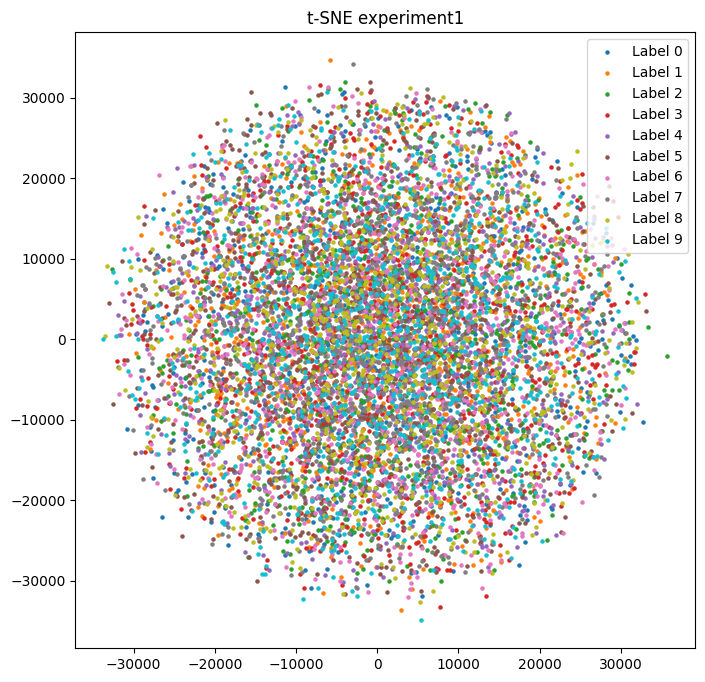


Plotting embeddings for experiment2...


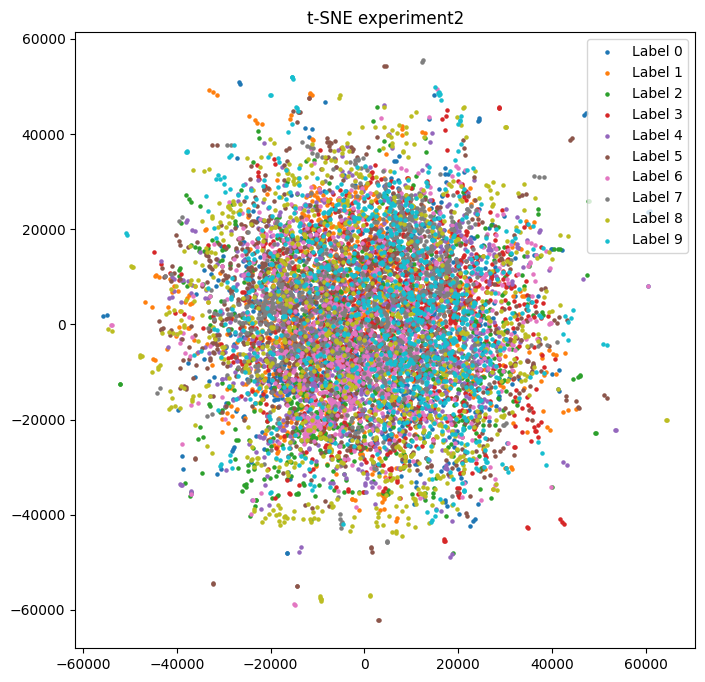


Plotting embeddings for experiment3...


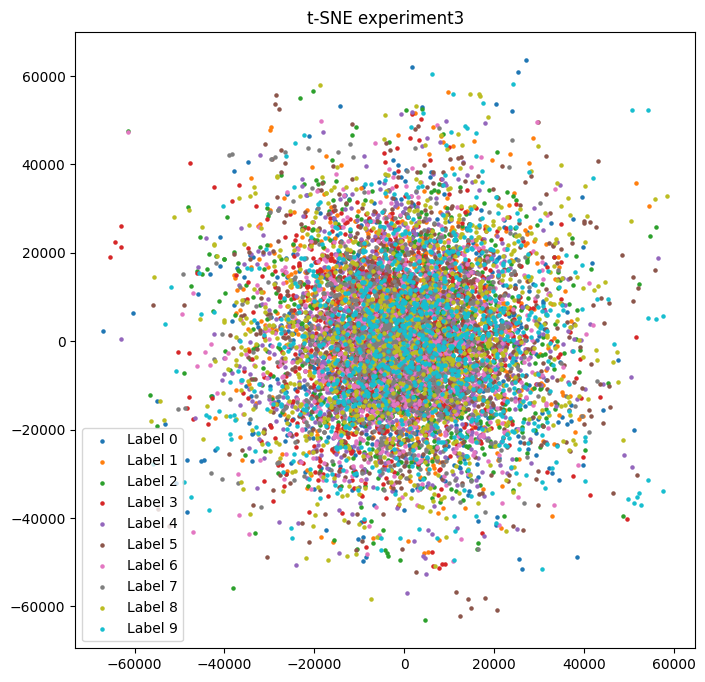


Plotting embeddings for experiment4...


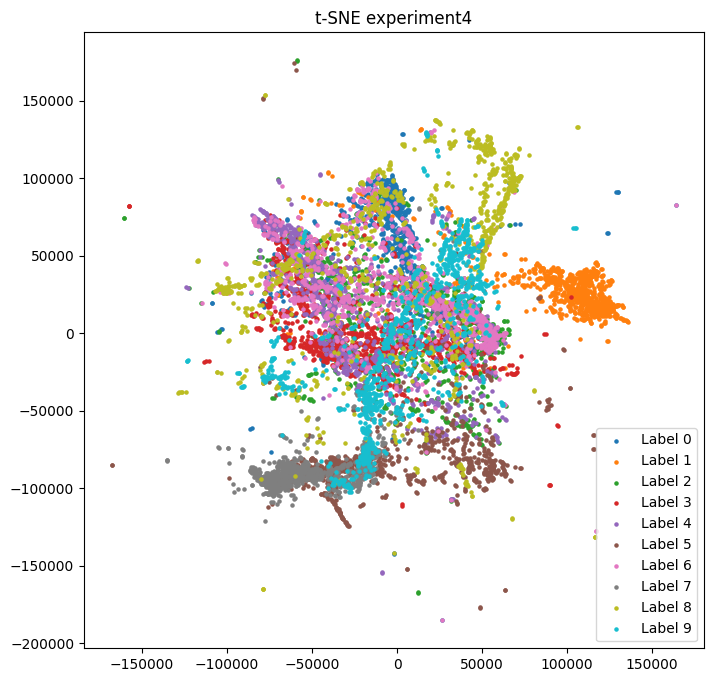


Plotting embeddings for experiment5...


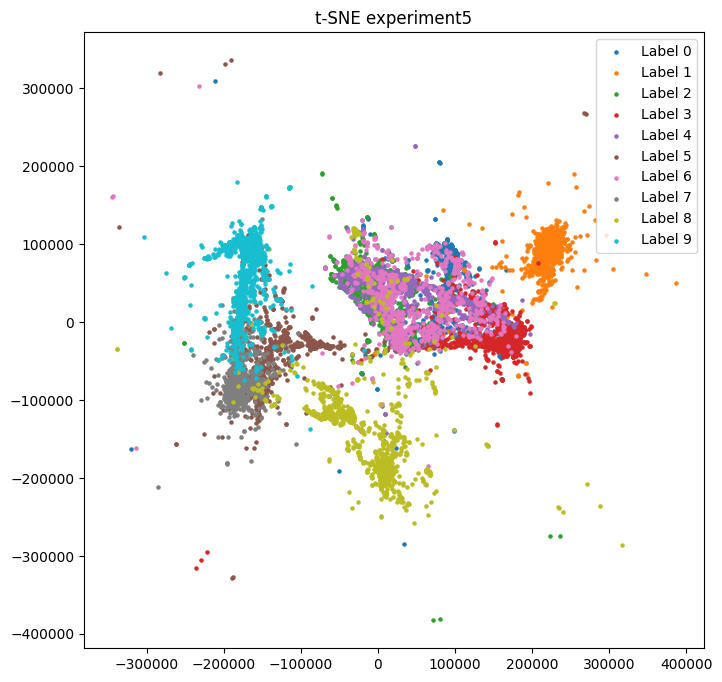


Plotting embeddings for experiment6...


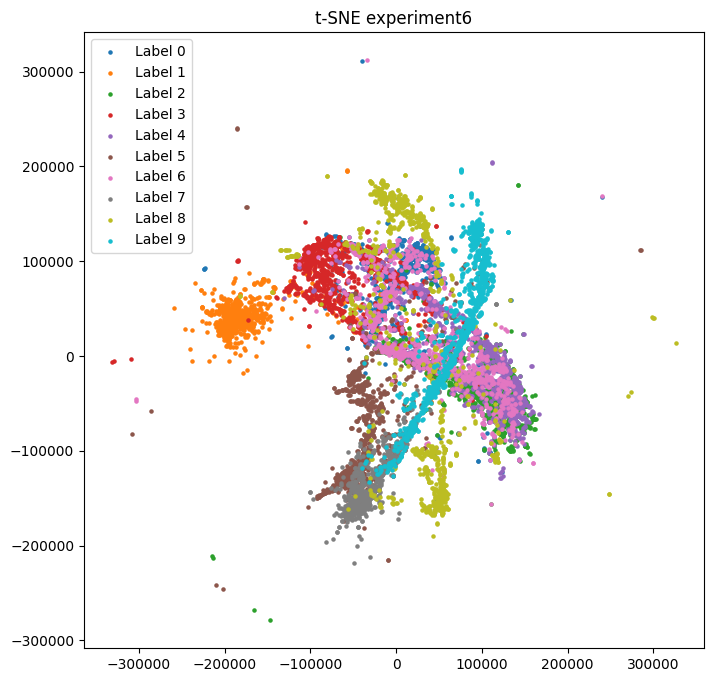


Plotting embeddings for experiment7...


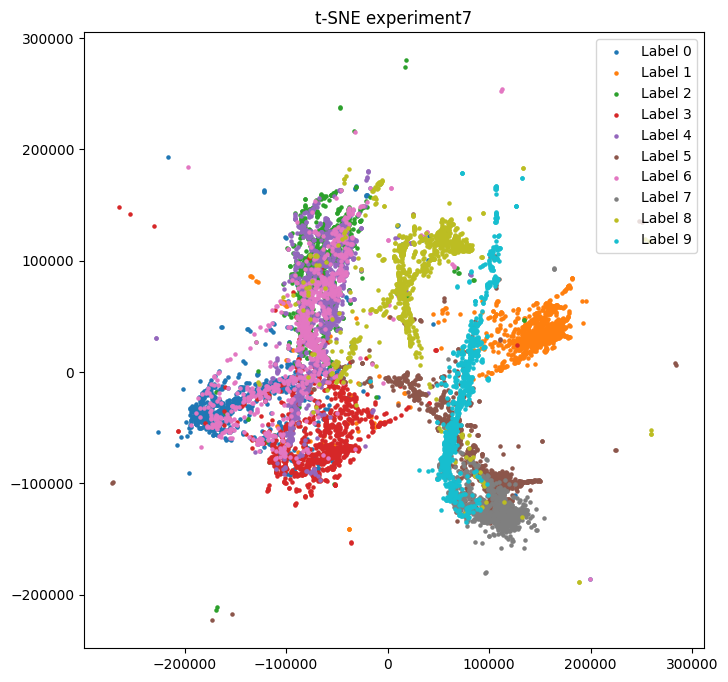

In [157]:
for config in embedding_configs:
    print(f"\nPlotting embeddings for {config['name']}...")
    load_and_plot(f"embeddings_{config['name']}.pt", f"t-SNE {config['name']}")


During my t-SNE experiments, I varied the configurations of learning rate, perplexity and number of iterations and observed distinct effects on the quality of the embeddings. The balanced results were provided by Experiment 7, which recorded a higher
D value meaning more successful inter-cluster separation and a J measure of moderate value which is reasonable for intra-cluster separation. Such results indicate that by adjusting the parameters such as the learning rate and perplexity downwards (say 100 and 40 respectively) I could do better in clustering. In Experiment 6, the clusters were quite separated, but the embeddings were more deviated and had a much higher J value meaning I still have more adjustments to carry out on the parameters. I may make the results better by trying a few lower learning rates which will help to reduce scatter by stabilizing the updates and varying the perplexity as a function of the size of datasets will improve local relationship capturing. Also, it is possible to steadily increase the number of iterations which may aid in improving the embeddings in a manner that doesn’t lead to overfitting or excessive separation of the clusters.